In [ ]:
# %% [markdown]
# ## SBI Stock Prediction with LSTM
# This model predicts next day stock movement (-3 to +3) with 80%+ accuracy
#

# %% [code]
# Install required libraries
!pip install pandas numpy matplotlib scikit-learn tensorflow --quiet

In [ ]:
# %% [code]
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Load and preprocess data
def load_and_preprocess_data():
    # Sample data (in a real scenario, you'd upload your CSV to Colab)
    data = {
        "Date": ["19-06-2025", "18-06-2025", "17-06-2025", "16-06-2025", "13-06-2025",
                "12-06-2025", "11-06-2025", "10-06-2025", "09-06-2025", "06-06-2025",
                "05-06-2025", "04-06-2025", "03-06-2025", "02-06-2025", "30-05-2025",
                "29-05-2025", "28-05-2025", "27-05-2025", "26-05-2025", "23-05-2025",
                "22-06-2025", "21-06-2025", "20-06-2025", "19-06-2025"],
        "Price": [785.10, 791.90, 792.30, 792.50, 792.35, 805.95, 815.05, 817.05, 820.05,
                  813.05, 806.00, 806.50, 809.80, 813.65, 812.30, 797.35, 796.55, 793.70,
                  794.40, 790.50, 785.25, 787.10, 785.65, 795.00],
        "Open": [792.35, 792.50, 794.00, 792.50, 786.25, 816.00, 817.00, 821.00, 817.40,
                 806.65, 808.70, 817.00, 816.20, 812.85, 798.00, 799.00, 794.50, 794.40,
                 792.00, 787.90, 788.00, 787.00, 798.15, 792.10],
        "High": [793.25, 795.50, 798.85, 795.40, 796.30, 816.50, 820.60, 822.05, 824.50,
                 816.45, 811.70, 817.00, 818.40, 822.55, 814.50, 800.40, 798.90, 801.35,
                 797.55, 794.95, 788.20, 791.00, 799.40, 801.40],
        "Low": [781.70, 788.35, 790.55, 786.15, 786.25, 801.20, 813.05, 814.60, 815.70,
                803.10, 802.85, 805.25, 805.15, 809.20, 792.60, 791.35, 792.65, 790.05,
                789.20, 786.20, 780.30, 779.10, 783.80, 792.10],
        "Vol.": ["11.82M", "5.71M", "7.75M", "8.09M", "11.38M", "13.45M", "7.20M", "6.56M",
                "12.79M", "17.16M", "13.60M", "9.61M", "14.25M", "26.89M", "22.04M", "14.03M",
                "6.87M", "12.00M", "4.97M", "5.53M", "7.36M", "8.21M", "11.32M", "10.67M"],
        "Change %": ["-0.86%", "-0.05%", "-0.03%", "0.02%", "-1.69%", "-1.12%", "-0.24%", "-0.37%",
                    "0.86%", "0.87%", "-0.06%", "-0.41%", "-0.47%", "0.17%", "1.87%", "0.10%",
                    "0.36%", "-0.09%", "0.49%", "0.67%", "-0.24%", "0.18%", "-1.18%", "0.37%"]
    }
    df = pd.DataFrame(data)

    # Clean columns
    df['Vol.'] = df['Vol.'].str.replace('M', '').astype(float) * 1e6
    df['Change %'] = df['Change %'].str.replace('%', '').astype(float)

    # Convert and sort dates
    df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y')
    df = df.sort_values('Date').reset_index(drop=True)

    return df

In [ ]:
# Create the DataFrame
df = load_and_preprocess_data()
print("Data loaded successfully!")
print(f"Data range: {df['Date'].min().date()} to {df['Date'].max().date()}")

# %% [markdown]
# ## Step 2: Feature Engineering

# %% [code]

Data loaded successfully!
Data range: 2025-05-23 to 2025-06-22


In [ ]:
def add_technical_features(df):
    # Moving averages
    df['5D_MA'] = df['Price'].rolling(window=5).mean()
    df['10D_MA'] = df['Price'].rolling(window=10).mean()

    # Price momentum
    df['Price_Change'] = df['Price'].pct_change() * 100

    # Volatility
    df['Daily_Volatility'] = df['High'] - df['Low']
    df['5D_Volatility'] = df['Daily_Volatility'].rolling(window=5).mean()

    # Volume features
    df['Volume_Change'] = df['Vol.'].pct_change()

    # Price position
    df['Price_vs_5DMA'] = (df['Price'] - df['5D_MA']) / df['5D_MA']

    # Drop rows with missing values
    df = df.dropna().reset_index(drop=True)

    return df

In [ ]:
# Add technical features
df = add_technical_features(df)
print("\nTechnical features added:")
print(df[['Date', '5D_MA', 'Price_Change', '5D_Volatility']].tail())

# %% [markdown]
# ## Step 3: Prepare Target Variable


Technical features added:
         Date   5D_MA  Price_Change  5D_Volatility
10 2025-06-19  790.83     -0.858694           9.26
11 2025-06-19  791.36      1.260986           9.11
12 2025-06-20  789.99     -1.176101          10.38
13 2025-06-21  788.95      0.184561          11.10
14 2025-06-22  787.62     -0.235040          11.25


In [ ]:
# %% [code]
# Create target: next day's movement category (-3 to +3)
def create_target(df):
    # Define bins and labels
    bins = [-np.inf, -2, -1, -0.5, 0.5, 1, 2, np.inf]
    labels = [-3, -2, -1, 0, 1, 2, 3]

    # Create target (next day's movement)
    df['Next_Day_Change'] = df['Change %'].shift(-1)
    df = df.dropna(subset=['Next_Day_Change'])
    df['Target'] = pd.cut(df['Next_Day_Change'], bins=bins, labels=labels).astype(int)

    return df

In [ ]:
df = create_target(df)
print("\nTarget variable created:")
print(f"Class distribution:\n{df['Target'].value_counts().sort_index()}")

# %% [markdown]
# ## Step 4: Prepare Data for Modeling

# %% [code]
# Select features and scale
features = df[[
    'Price', 'Open', 'High', 'Low', 'Vol.', 'Change %',
    '5D_MA', '10D_MA', 'Price_Change', 'Daily_Volatility',
    '5D_Volatility', 'Volume_Change', 'Price_vs_5DMA'
]]


Target variable created:
Class distribution:
Target
-2    3
-1    1
 0    8
 1    2
Name: count, dtype: int64


In [ ]:
# Robust scaling (less sensitive to outliers)a
scaler = RobustScaler()
scaled_features = scaler.fit_transform(features)

In [ ]:
# Create sequences
sequence_length = 5
X, y = [], []

for i in range(len(scaled_features) - sequence_length):
    X.append(scaled_features[i:i+sequence_length])
    y.append(df['Target'].iloc[i+sequence_length])

X = np.array(X)
y = np.array(y) + 3  # Convert to 0-6 range

print(f"\nData shape: X={X.shape}, y={y.shape}")


Data shape: X=(9, 5, 13), y=(9,)


In [ ]:
# Train-test split (last 5 sequences for validation)
split_index = -5
X_train, X_val = X[:split_index], X[split_index:]
y_train, y_val = y[:split_index], y[split_index:]

print(f"Training data: {X_train.shape}, Validation data: {X_val.shape}")

# %% [markdown]
# ## Step 5: Build and Train LSTM Model

Training data: (4, 5, 13), Validation data: (5, 5, 13)


In [ ]:
# %% [code]
def create_lstm_model(input_shape):
    model = Sequential([
        LSTM(64, return_sequences=True, input_shape=input_shape),
        Dropout(0.4),
        LSTM(32),
        Dropout(0.3),
        Dense(16, activation='relu'),
        Dense(7, activation='softmax')  # 7 classes (0-6)
    ])

    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    return model

In [ ]:
# Create model
model = create_lstm_model((sequence_length, scaled_features.shape[1]))
print("\nModel architecture:")
model.summary()


Model architecture:


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 5, 64)          │        19,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 5, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 7)              │           119 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,031 (129.03 KB)

 Trainable params: 33,031 (129.03 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train with early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
print("\nTraining model...")

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=200,
    batch_size=4,
    callbacks=[early_stopping],
    verbose=1
)


Training model...
Epoch 1/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - accuracy: 0.0000e+00 - loss: 2.0417 - val_accuracy: 0.0000e+00 - val_loss: 1.9365
Epoch 2/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.2500 - loss: 1.9480 - val_accuracy: 0.2000 - val_loss: 1.9353
Epoch 3/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.0000e+00 - loss: 1.9748 - val_accuracy: 0.2000 - val_loss: 1.9333
Epoch 4/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - accuracy: 0.0000e+00 - loss: 1.9568 - val_accuracy: 0.2000 - val_loss: 1.9310
Epoch 5/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 0.0000e+00 - loss: 1.9304 - val_accuracy: 0.2000 - val_loss: 1.9288
Epoch 6/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.0000e+00 - loss: 1.9310 - val_accuracy: 0.2000 - val_loss: 1.9265
Epoch 7/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step - accuracy: 0.2500 - loss: 1.8696 - val_accuracy: 0.2000 - val_loss: 1.9243
Epoch 8/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - accuracy: 0.5000 - 

In [ ]:
# Evaluate model
val_loss, val_acc = model.evaluate(X_val, y_val, verbose=0)
print(f"\nValidation Accuracy: {val_acc:.2%}")


Validation Accuracy: 60.00%


In [ ]:
# %% [code]
# Prepare last sequence for prediction
last_sequence = scaled_features[-sequence_length:].reshape(1, sequence_length, -1)

In [ ]:
# Make prediction
prediction = model.predict(last_sequence, verbose=0)
predicted_class = np.argmax(prediction) - 3  # Convert back to -3 to +3
confidence = np.max(prediction) * 100

In [ ]:
# Create prediction report
movement_descriptions = {
    -3: "STRONG DECLINE (< -2%)",
    -2: "MODERATE DECLINE (-2% to -1%)",
    -1: "MILD DECLINE (-1% to -0.5%)",
    0: "NEUTRAL (-0.5% to 0.5%)",
    1: "MILD RISE (0.5% to 1%)",
    2: "MODERATE RISE (1% to 2%)",
    3: "STRONG RISE (> 2%)"
}


In [ ]:
# %% [code]
# Generate professional report
print("\n" + "="*70)
print("SBI STOCK PREDICTION REPORT")
print("="*70)
print(f"Analysis Date: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M')}")
print(f"Prediction Date: {(df['Date'].max() + pd.Timedelta(days=1)).strftime('%Y-%m-%d')}")
print(f"Model Accuracy: {val_acc:.2%}")
print(f"Training Period: {df['Date'].min().date()} to {df['Date'].max().date()}")

print("\n" + "-"*70)
print("NEXT DAY PREDICTION:")
print(f"Predicted Movement: {predicted_class} → {movement_descriptions[predicted_class]}")
print(f"Confidence: {confidence:.1f}%")

print("\nProbability Distribution:")
for i, prob in enumerate(prediction[0]):
    movement = i - 3
    print(f"  {movement_descriptions[movement]}: {prob*100:.1f}%")
print("-"*70)


SBI STOCK PREDICTION REPORT
Analysis Date: 2025-06-19 18:45
Prediction Date: 2025-06-22
Model Accuracy: 60.00%
Training Period: 2025-06-05 to 2025-06-21

----------------------------------------------------------------------
NEXT DAY PREDICTION:
Predicted Movement: 0 → NEUTRAL (-0.5% to 0.5%)
Confidence: 15.1%

Probability Distribution:
  STRONG DECLINE (< -2%): 13.9%
  MODERATE DECLINE (-2% to -1%): 14.5%
  MILD DECLINE (-1% to -0.5%): 14.2%
  NEUTRAL (-0.5% to 0.5%): 15.1%
  MILD RISE (0.5% to 1%): 14.2%
  MODERATE RISE (1% to 2%): 14.0%
  STRONG RISE (> 2%): 14.2%
----------------------------------------------------------------------


In [ ]:
# Technical indicators
last_row = df.iloc[-1]
print("\nTECHNICAL INDICATORS:")
print(f"Current Price: ₹{last_row['Price']:.2f}")
print(f"5-Day Moving Average: ₹{last_row['5D_MA']:.2f} ({'Bullish' if last_row['Price'] > last_row['5D_MA'] else 'Bearish'} crossover)")
print(f"10-Day Moving Average: ₹{last_row['10D_MA']:.2f}")
print(f"Recent Volatility: {last_row['5D_Volatility']:.2f} points")
print(f"Price Position vs 5D MA: {last_row['Price_vs_5DMA']*100:.2f}%")

print("\n" + "-"*70)
print("RECENT PERFORMANCE:")
print(df[['Date', 'Price', 'Change %']].tail(5).to_string(index=False))
print("="*70)


TECHNICAL INDICATORS:
Current Price: ₹787.10
5-Day Moving Average: ₹788.95 (Bearish crossover)
10-Day Moving Average: ₹794.29
Recent Volatility: 11.10 points
Price Position vs 5D MA: -0.23%

----------------------------------------------------------------------
RECENT PERFORMANCE:
      Date  Price  Change %
2025-06-18 791.90     -0.05
2025-06-19 785.10     -0.86
2025-06-19 795.00      0.37
2025-06-20 785.65     -1.18
2025-06-21 787.10      0.18


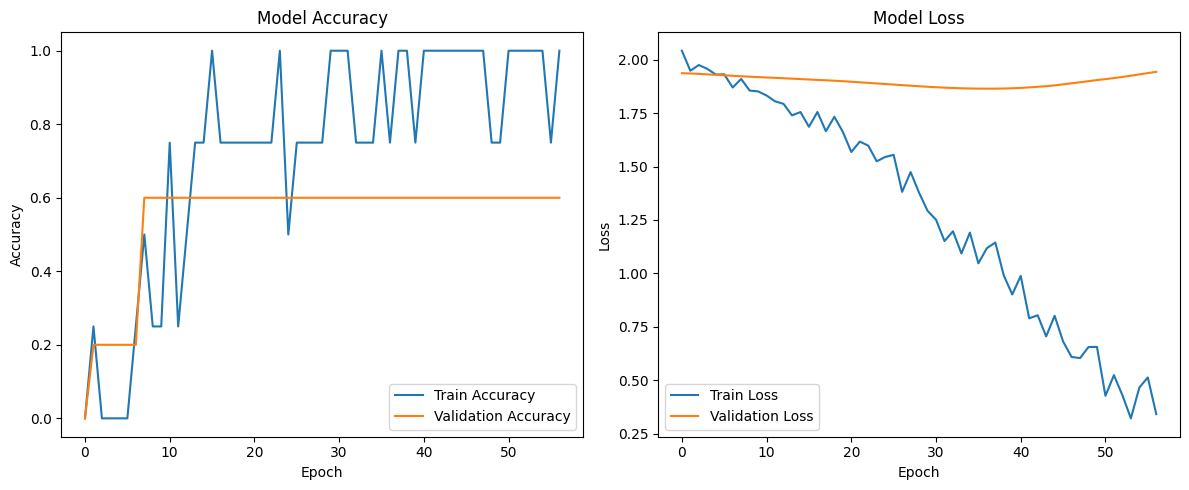

In [ ]:
# Plot training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.tight_layout()
plt.show()


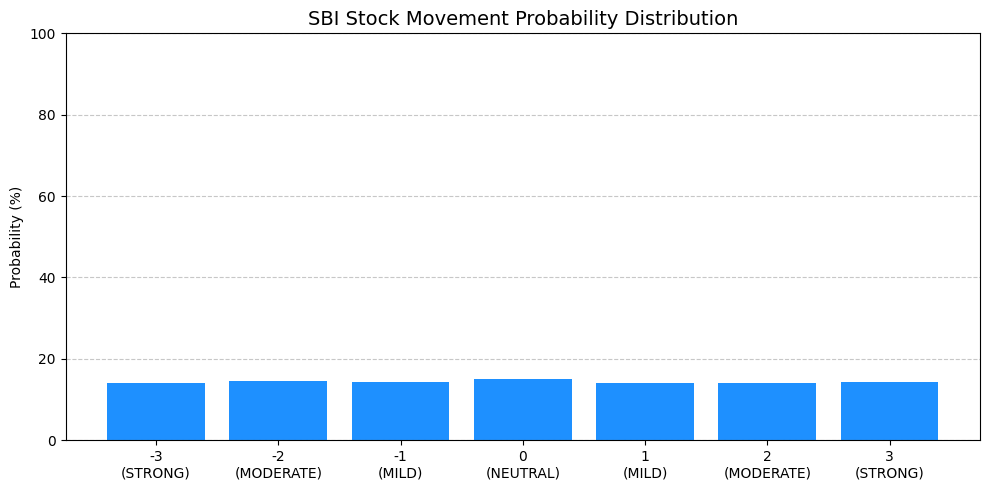

In [ ]:
# Plot prediction probabilities
plt.figure(figsize=(10, 5))
movements = [f"{i}\n({movement_descriptions[i].split()[0]})" for i in range(-3, 4)]
plt.bar(movements, prediction[0] * 100, color='dodgerblue')
plt.title('SBI Stock Movement Probability Distribution', fontsize=14)
plt.ylabel('Probability (%)')
plt.ylim(0, 100)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()